In [1]:
from pennylane import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns

from utils.tools import get_dataset, visualise_data

2025-03-20 11:30:28.048368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742430628.064460  242013 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742430628.069358  242013 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742430628.081857  242013 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742430628.081874  242013 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742430628.081876  242013 computation_placer.cc:177] computation placer alr

I0000 00:00:1742430630.326568  242013 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11433 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:02:00.0, compute capability: 6.0


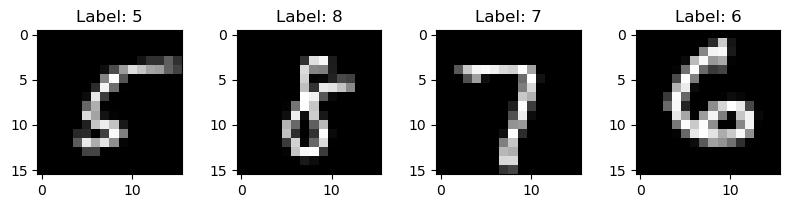

In [2]:
digits = [5,8,7,6]
n_px = 16

(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

# show one image from each class
x_vis = [(x_train[y_train==digit])[np.random.choice(range(10))] for digit in digits] 
y_vis = range(len(digits))

visualise_data(digits, x_vis, y_vis)

### Classical model

In [3]:
def create_classical_model(n_px):
    model = keras.Sequential([
        keras.Input(shape=(n_px,n_px,1)),
        keras.layers.Flatten(),
        # select the dense layer outputs to match quantum model characteristics
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    return model

def create_classical_model_CNN(n_px):
    model = keras.Sequential([
        keras.Input(shape=(n_px,n_px,1)),
        keras.layers.Conv2D(32, [3,3], activation='relu'),
        keras.layers.Conv2D(64, [3, 3], activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])

    return model

In [4]:
classical_model = create_classical_model(n_px)
classical_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
classical_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,146 (8.38 KB)

 Trainable params: 2,146 (8.38 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
classical_model_CNN = create_classical_model_CNN(n_px)
classical_model_CNN.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
classical_model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,146 (1.20 MB)

 Trainable params: 315,146 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
c_history = classical_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=30,
    verbose=1
)

# classical_model_results = classical_model.evaluate(x_test, y_test)

Epoch 1/30


I0000 00:00:1742430632.078836  242085 service.cc:152] XLA service 0x7fbd4c009170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742430632.078855  242085 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2025-03-20 11:30:32.095662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742430632.165331  242085 cuda_dnn.cc:529] Loaded cuDNN version 90300


 47/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2027 - loss: 2.1615    

I0000 00:00:1742430632.524506  242085 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3201 - loss: 1.8766 - val_accuracy: 0.7050 - val_loss: 0.9660
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8149 - loss: 0.7561 - val_accuracy: 0.8550 - val_loss: 0.5197
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9194 - loss: 0.3877 - val_accuracy: 0.9100 - val_loss: 0.3591
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9349 - loss: 0.2793 - val_accuracy: 0.9200 - val_loss: 0.2959
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9428 - loss: 0.2473 - val_accuracy: 0.9200 - val_loss: 0.2657
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9409 - loss: 0.2131 - val_accuracy: 0.9450 - val_loss: 0.2360
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9631 - loss: 0.1500 - val_accuracy: 0.9450 - val_loss: 0.2247
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9564 - loss: 0.1675 - val_accuracy: 0.9450 - val_

In [7]:
CNN_history = classical_model_CNN.fit(x_train,
                   y_train,
                   batch_size=4,
                   epochs=30,
                   verbose=1,
                   validation_data=(x_test, y_test))

Epoch 1/30


2025-03-20 11:30:57.321378: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[4,64,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,14,14]{3,2,1,0} %bitcast.7131, f32[64,32,3,3]{3,2,1,0} %bitcast.6652, f32[64]{0} %bitcast.7191), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1_2/convolution" source_file="/home/pranay/miniforge3/envs/qml/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5697 - loss: 1.0690     

2025-03-20 11:30:59.969657: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[4,64,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,14,14]{3,2,1,0} %bitcast.511, f32[64,32,3,3]{3,2,1,0} %bitcast.518, f32[64]{0} %bitcast.520), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1_2/convolution" source_file="/home/pranay/miniforge3/envs/qml/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5746 - loss: 1.0577 - val_accuracy: 0.9400 - val_loss: 0.1776
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9304 - loss: 0.1901 - val_accuracy: 0.9650 - val_loss: 0.0873
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9707 - loss: 0.0831 - val_accuracy: 0.9600 - val_loss: 0.1220
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9833 - loss: 0.0686 - val_accuracy: 0.9850 - val_loss: 0.0546
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9809 - loss: 0.0550 - val_accuracy: 0.9750 - val_loss: 0.0996
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9883 - loss: 0.0365 - val_accuracy: 0.9600 - val_loss: 0.1207
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9899 - loss: 0.0364 - val_accuracy: 0.9750 - val_loss: 0.0588
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9881 - loss: 0.0342 - val_accuracy: 0.9650 - val_

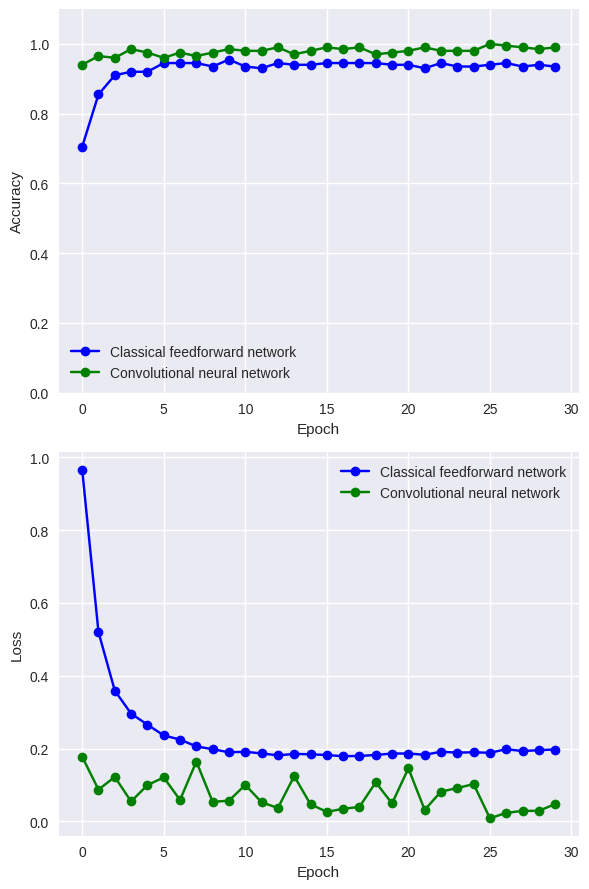

In [8]:
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(2, 1, figsize=(6,9))

ax[0].plot(c_history.history["val_accuracy"], "-ob", label="Classical feedforward network")
ax[0].plot(CNN_history.history["val_accuracy"], "-og", label="Convolutional neural network")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 1.1])
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(c_history.history["val_loss"], "-ob", label="Classical feedforward network")
ax[1].plot(CNN_history.history["val_loss"], "-og", label="Convolutional neural network")
ax[1].set_ylabel("Loss")
# ax[1].set_ylim(top=2.5)
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.tight_layout()
plt.show()

For quantum model see other notebook.